# NFL Fantasy Player Ranking

The goal of this project is to be able to rank fantasy players based on past statistics. We will use clustering algorithmns to be able to rank players into distinguishable tiers. Ideally, this model can be used weekly throughout the NFL season based on solely this seasons performance.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

### Initial Data importing and cleanup

In [2]:
#importing data
stats = pd.read_csv('fantasy.txt')

#replacing all NAs with 0
stats.fillna(value = 0, inplace = True)

#filtering for players that only had greater than 0 points
stats = stats[stats.FantPt >= 16]

#first we will reorder the dataframe from highest to lowest points scored
#normal leagues
stats_norm = stats.sort_values('FantPt', ascending = False)

#ppr leagues
stats_ppr = stats.sort_values('PPR', ascending = False)

#std predictors
std_predictors = ['Player', 'G', 'GS', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Att.1',
                  'Yds.1', 'Y/A', 'TD.1', 'Tgt', 'Rec', 'Yds.2', 'Y/R',
                  'TD.2', 'Fmb', 'FL', 'TD.3', '2PM', '2PP', 'FantPt']
#ppr predictors 
ppr_predictors = ['Player', 'G', 'GS', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Att.1',
                  'Yds.1', 'Y/A', 'TD.1', 'Tgt', 'Rec', 'Yds.2', 'Y/R',
                  'TD.2', 'Fmb', 'FL', 'TD.3', '2PM', '2PP','PPR']

#all relevant predictors to use for std PCA
df_std = stats.filter(items = std_predictors)

#all relevant predictors to use for PPR PCA
df_ppr = stats.filter(items = ppr_predictors)


#storing index as player names for std
df_std.set_index('Player', inplace = True)

#storing index as player names for ppr
df_ppr.set_index('Player', inplace = True)

#STD standardizing data
df_std = StandardScaler().fit_transform(df_std)

#PPR standardizing data
df_ppr = StandardScaler().fit_transform(df_ppr)

E:\Code\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\Code\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
E:\Code\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\Code\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Principial Component Analysis

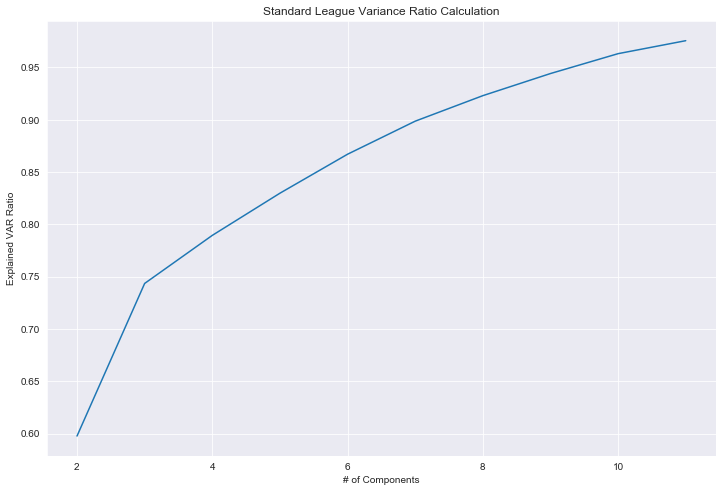

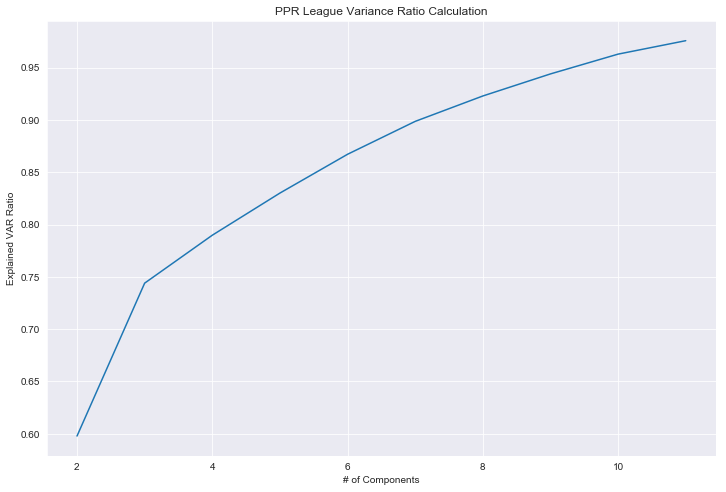

In [3]:
#function that allows us to do PCA and returns its variance ratio and a graph
#The parameters are:
#x - which is the maximum number of components
#data - the data in question that we are performing PCA
#df_name - name that will be used as title for graph

def pca_variance_check(x, data, df_name):
    #empty list to store variance ratio
    pca_variance_list = []

    #for loop that serachs for best ratio

    for i in range(2,x):
        pca = PCA(i, random_state = 0)
        components = pca.fit_transform(data)
        pca_variance = sum(pca.explained_variance_ratio_)
        pca_variance_list.append(pca_variance)

    #plotting our variance
    #changing style
    sns.set_style('darkgrid')

    #changing fig size
    plt.figure(figsize = (12,8))

    #plotting our variance
    ax = sns.lineplot(range(2,x), pca_variance_list)

    #plot labels
    ax.set(xlabel = '# of Components', ylabel = 'Explained VAR Ratio', 
           title = df_name + ' Variance Ratio Calculation')
    return(pca_variance_list)
    
std_var = pca_variance_check(12, df_std, 'Standard League')
ppr_var = pca_variance_check(12, df_ppr, 'PPR League')

So luckily for us both graphs have VERY similar VAR ratio explained so what we will do is use a fixed number of components for each type of scoring. Since we can't tell much from these graphs we will instead calculate the difference between components. So, the difference between 4 to 5, 5 to 6, etc. (essentially the derivative at each point.

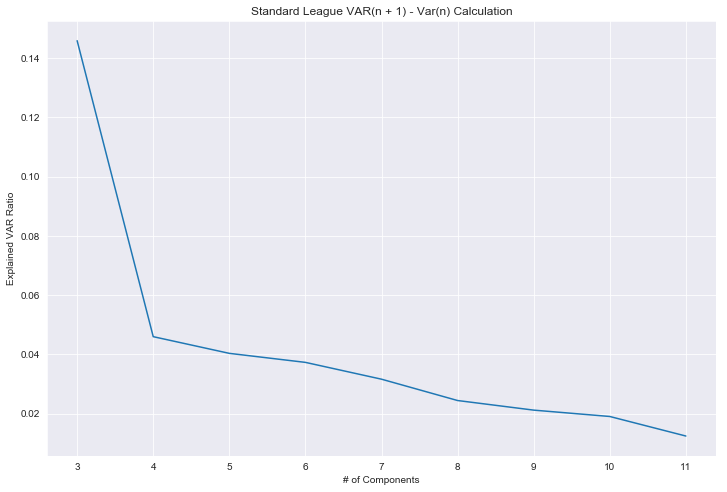

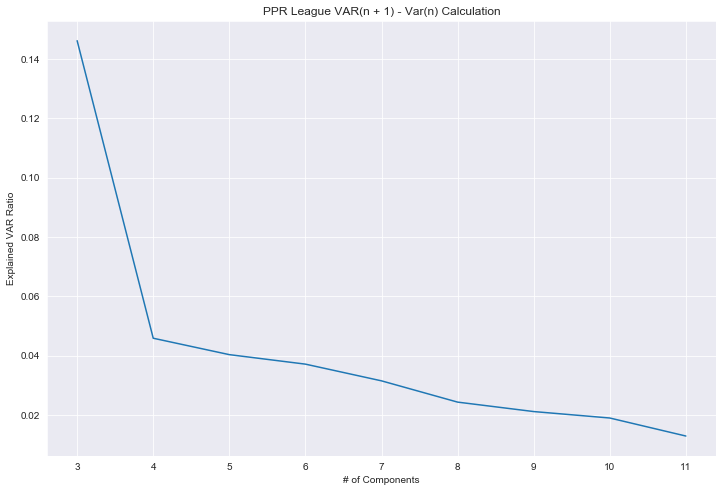

In [4]:
#function that calculates the difference between components and prints a graph
#the parameters are:
#data - list of VAR ratio
#df_name - name that will be used as title for graph

def component_diff(data, df_name):
    #calculating difference
    dy = np.diff(data)

    #changing fig size
    plt.figure(figsize = (12,8))

    #plotting our variance
    ax = sns.lineplot(range(3,12), dy)

    #plot labels
    ax.set(xlabel = '# of Components', ylabel = 'Explained VAR Ratio',
           title = df_name + ' VAR(n + 1) - Var(n) Calculation')
    return(dy)

std_diff = component_diff(std_var, 'Standard League')
ppr_diff = component_diff(ppr_var, 'PPR League')

As we can see there is a sharp decrease as we move from 4 components to 5 components. This tells us that when we increase our number of principal components from 4 to 5 our explained variance ratio only increases slightly. So, to keep our model simplier we will use 4 components.

So do PCA for STD vs PPR leagues,
Give each data frame Player name as index and position.
Then subset all the dataframe into each position and use GMM on said.

In [5]:
#function that will gets us a df into 4 components using PCA
#parameters are:
#data - data to perform PCA on
#index_names - name of index (player names in this case)
#position_names - positions of players

def pca_4(data, index_names, position_names):
    #running PCA
    pca = PCA(n_components = 4)

    #getting our components
    components = pca.fit_transform(data)

    #getting our new dataframe
    pca_df = pd.DataFrame(components, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])

    #adding player names
    pca_df['Player'] = index_names
    
    #adding positions
    pca_df['Position'] = position_names

    #converting player names to index values
    pca_df.set_index('Player', inplace = True)

    #checking our variance ratio
    var_sum = sum(pca.explained_variance_ratio_)
    
    return(pca_df, var_sum)

a, b = pca_4(df_std, stats_norm.Player, stats_norm.FantPos)
a2, b2 = pca_4(df_ppr, stats_ppr.Player, stats_norm.FantPos)

# FILTER THESE PLAYERS BASED ON POSITION

In [6]:
#filtering players based on position

#poisitions list to parse through
positions = ['QB', 'RB', 'WR', 'TE']

#empty dict to store individual position data for normal leagues
stats_norm_pos = {}
stats_ppr_pos = {}

#for loop that stores each position data into dict
for position in positions:
    stats_norm_pos[position] = a[a.Position == position]
    stats_ppr_pos[position] = a2[a2.Position == position]

#now we remove the position column for each position

# Gaussian Mixture Modeling

For our first model we will be using Gaussian Mixture. Just like when we used PCA we need to find the right number of clusters. In order to do so we will look at silhouette scores.

In [7]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture


#list to hold silhouette scores
silhouette_gmm = []

#we will look from 4 to 10 clusters
for j in range(2, 11):
    gmm = GaussianMixture(n_components = j, random_state = 0).fit(a2)
    #get labels
    labels = gmm.predict(a2)
    #insert score into list
    silhouette_gmm.append(silhouette_score(a2, labels))

#plotting our silhouette scores for readability.

#changing fig size
plt.figure(figsize = (12,8))

#plotting our variance
ax = sns.lineplot(range(2,11), silhouette_gmm)

#plot labels
ax.set(xlabel = '# of Clusters', ylabel = 'Silhouette Scores', 
       title = 'Cluster Silhouette Scores')
plt.show()

ValueError: could not convert string to float: 'RB'

One of the main problems with finding identifiable clusters is that we simply do not care about the lower end really. The difference between a Tier 1 player and a Tier 2 player isn't the same as a Tier 2 player and a Tier 3 player. In general the furthur down you go the bigger the gap between players. So in order to prevent creating an enormous amount of tiers, we will look for something in the 2-10 range. Since our scores are relatively small, we will pick the highest score which is 8.

In [ ]:
#gmm using 6 components
gmm = GaussianMixture(n_components = 8, covariance_type = 'full', random_state = 0).fit(a)

#labeling our points based on GMM
labels = gmm.predict(a)

results = pd.DataFrame()
results['Player'] = a.index.values
results['Cluster Number'] = labels

#This clustering type gives you the 7 different player types